In [1]:
%matplotlib inline

# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

### Dependencies

In [2]:
import matplotlib.pyplot as plt

### Import downloader behaviours

In [3]:
from PIL import Image
import os
import os.path
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data

import os
import os.path
import hashlib
import errno
from torch.utils.model_zoo import tqdm

## UTILS FUNCTION from https://github.com/pytorch/vision/blob/master/torchvision/datasets/utils.py

def check_integrity(fpath, md5=None):
    if md5 is None:
        return True
    if not os.path.isfile(fpath):
        return False
    md5o = hashlib.md5()
    with open(fpath, 'rb') as f:
        # read in 1MB chunks
        for chunk in iter(lambda: f.read(1024 * 1024), b''):
            md5o.update(chunk)
    md5c = md5o.hexdigest()
    if md5c != md5:
        return False
    return True


def download_url(url, root, filename=None, md5=None):
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    from six.moves import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    makedir_exist_ok(root)

    # downloads file
    if os.path.isfile(fpath) and check_integrity(fpath, md5):
        print('Using downloaded and verified file: ' + fpath)
    else:
        try:
            print('Downloading ' + url + ' to ' + fpath)
            urllib.request.urlretrieve(
                url, fpath,
                reporthook=gen_bar_updater()
            )
        except OSError:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('Failed download. Trying https -> http instead.'
                      ' Downloading ' + url + ' to ' + fpath)
                urllib.request.urlretrieve(
                    url, fpath,
                    reporthook=gen_bar_updater()
                )

def makedir_exist_ok(dirpath):
    """
    Python2 support for os.makedirs(.., exist_ok=True)
    """
    try:
        os.makedirs(dirpath)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
            
def gen_bar_updater():
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update

## CIFAR DATASET DOWNLOADER from https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py
    
class CIFAR10(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists or will be saved to if download is set to True.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]
    meta = {
        'filename': 'batches.meta',
        'key': 'label_names',
        'md5': '5ff9c542aee3614f3951f8cda6e48888',
    }

    def __init__(self, root, train=True,
                 transform=None, target_transform=None,
                 download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        if self.train:
            downloaded_list = self.train_list
        else:
            downloaded_list = self.test_list

        self.data = []
        self.targets = []

        # now load the picked numpy arrays
        for file_name, checksum in downloaded_list:
            file_path = os.path.join(self.root, self.base_folder, file_name)
            with open(file_path, 'rb') as f:
                if sys.version_info[0] == 2:
                    entry = pickle.load(f)
                else:
                    entry = pickle.load(f, encoding='latin1')
                self.data.append(entry['data'])
                if 'labels' in entry:
                    self.targets.extend(entry['labels'])
                else:
                    self.targets.extend(entry['fine_labels'])

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

        self._load_meta()

    def _load_meta(self):
        path = os.path.join(self.root, self.base_folder, self.meta['filename'])
        if not check_integrity(path, self.meta['md5']):
            raise RuntimeError('Dataset metadata file not found or corrupted.' +
                               ' You can use download=True to download it')
        with open(path, 'rb') as infile:
            if sys.version_info[0] == 2:
                data = pickle.load(infile)
            else:
                data = pickle.load(infile, encoding='latin1')
            self.classes = data[self.meta['key']]
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        # extract file
        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]
    meta = {
        'filename': 'meta',
        'key': 'fine_label_names',
        'md5': '7973b15100ade9c7d40fb424638fde48',
    }

### Run test downloading

In [4]:
DATASET_PATH = "dataset"
TRAIN_BATCH_PATH = "/".join([DATASET_PATH, "cifar-10-batches-py", "data_batch_1"])
TEST_BATCH_PATH = "/".join([DATASET_PATH, "cifar-10-batches-py", "test_batch"])


In [5]:
print("Download train dataset")
downloader_train = CIFAR10(root=DATASET_PATH, train=True, transform=None, target_transform=None, download=True)


Download train dataset
Files already downloaded and verified


### Unpack the dataset

In [6]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

train_data_dict = unpickle(TRAIN_BATCH_PATH)
test_data_dict = unpickle(TEST_BATCH_PATH)

X_train shape (100, 32, 32, 3)
X_left shape (9900, 32, 32, 3)
X_test shape (10000, 32, 32, 3)


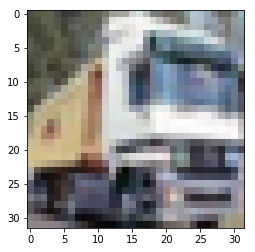

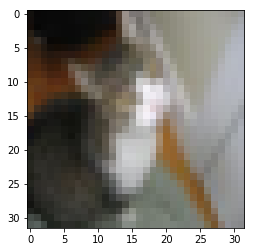

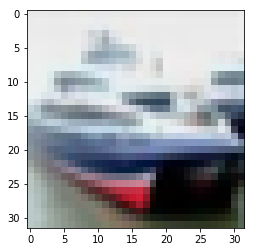

In [7]:
def custom_dataset_process(data_dict, n_start = 0, n_end=None):
    """ Load the CIFAR10 data as intended for this project
    :param data_dict: dict, dictionnary generated by the unpickle function
    :param n_start: integer, default=None, index value of the first elements to take
    :param n_end: integer, default=None, index value of the last elements to take
    :return x: np.array, data array with shape n*32*32*3, with n number of images, of shape 32*32 in 3 colors"""
    
    labels = data_dict[b"labels"][n_start:n_end]
    data = data_dict[b"data"][n_start:n_end]
        
    les_im = np.array(data)
    les_im_reshape = []
    for id_im, im in enumerate(les_im):
        im_reshape = np.rot90(im.reshape((32, 32, 3), order="F"), k=3)
        les_im_reshape.append(im_reshape)
    
    les_im_reshape = np.array(les_im_reshape)
    return les_im_reshape, labels

X_train, X_train_labels = custom_dataset_process(train_data_dict, n_start=0, n_end=100)
X_left, X_left_labels = custom_dataset_process(train_data_dict, n_start=100, n_end=None)
X_test, X_test_labels = custom_dataset_process(test_data_dict)

def show_dataset():
    for X in [["X_train", X_train], ["X_left", X_left], ["X_test", X_test]]:
        print(X[0], "shape", X[1].shape)
        plt.figure()
        plt.imshow(X[1][1])

show_dataset()

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Evaluation of the training procedure may be difficult because of the low number of labeled data we are using for the model training. We may have quite a hard time resolving overfitting problems: we have few gold data.

As seen in the class, solutions exists:
- We can use semi-supervized learning to try to make guesses about unlabeled train data
- Use transfer learning, and just fine-tune our model without the need of a huge great dataset
- Weak supervision or traditional supervision are also existing solutions, but we will not use them as they involve to ask for a new labelling round, even at higher/abstract level.

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

### Kuangliu implementation

In [8]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())

    
test()

torch.Size([1, 10])


#### Utils : https://github.com/kuangliu/pytorch-cifar/blob/master/utils.py

In [9]:
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math

import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


# _, term_width = os.popen('stty size', 'r').read().split()
# term_width = int(term_width)
term_width = 1
TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

#### Adapted from main https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


class Args:
    def __init__(self, lr, try_cuda):
        self.lr = lr
        self.try_cuda = try_cuda

args = Args(lr=0.1, try_cuda=False)

device = 'cuda' if torch.cuda.is_available() and args.try_cuda else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('==> Building model..')
# net = VGG('VGG19')
net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.t7')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test(epoch)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0


Traceback (most recent call last):
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/paul/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + 

KeyboardInterrupt: 

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [15]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print("model_names", model_names)

parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
parser.add_argument('data', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--arch', '-a', metavar='ARCH', default='resnet18',
                    choices=model_names,
                    help='model architecture: ' +
                        ' | '.join(model_names) +
                        ' (default: resnet18)')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=90, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=256, type=int,
                    metavar='N', help='mini-batch size (default: 256)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=10, type=int,
                    metavar='N', help='print frequency (default: 10)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')

class Args:
    def __init__(self, data="dataset", arch="resnet_18", workers=4, epochs=99, start_epoch=0, lr=0.1, momentum=0.9, weight_decay=1e-4, resume="", evaluate=True, pretrained=True):
      self.data = data
      self.arch = arch
      self.workers = workers
      self.epochs = epochs
      self.start_epoch = start_epoch
      self.lr = lr
      self.momentum = momentum
      self.weight_decay = weight_decay
      self.resume = resume
      self.evaluate = evaluate
      self.pretrained = pretrained


best_prec1 = 0


def main():
    global args, best_prec1
#     args = parser.parse_args()
    args = Args()
  
    ## Dataset adaptation to torch 
    # Transform into torch tensor
    X_train_torch = torch.from_numpy(X_train)
    X_train_labels_torch = torch.from_numpy(X_tr
    
    
    # create model
    if args.pretrained:
        print("=> using pre-trained model '{}'".format(args.arch))
        model = models.__dict__[args.arch](pretrained=True)
    else:
        print("=> creating model '{}'".format(args.arch))
        model = models.__dict__[args.arch]()

    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()

    cudnn.benchmark = True

    # Data loading code
#     traindir = os.path.join(args.data, 'train')
#     valdir = os.path.join(args.data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

#     train_loader = torch.utils.data.DataLoader(
#         datasets.ImageFolder(traindir, transforms.Compose([
#             transforms.RandomSizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ])),
#         batch_size=args.batch_size, shuffle=True,
#         num_workers=args.workers, pin_memory=True)

#     val_loader = torch.utils.data.DataLoader(
#         datasets.ImageFolder(valdir, transforms.Compose([
#             transforms.Scale(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             normalize,
#         ])),
#         batch_size=args.batch_size, shuffle=False,
#         num_workers=args.workers, pin_memory=True)

    # Create dataset and dataloader objects
    train_dataset = torch.utils.TensorDataset(X_train_torch, X_train_labels_torch)
    train_loader = torch.utils.DataLoader(train_dataset, 
                                    batch_size=args.batch_size, 
                                    shuffle=True,
                                    num_workers=args.workers, 
                                    pin_memory=True
                                   )
    
    val_dataset = torch.utils.TensorDataset(X_test_torch, X_test_labels_torch)
    val_loader = torch.utils.DataLoader(val_dataset, 
                                    batch_size=args.batch_size, 
                                    shuffle=True,
                                    num_workers=args.workers, 
                                    pin_memory=True
                                   )


    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    if args.evaluate:
        validate(val_loader, model, criterion)
        return

    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.arch,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best)


def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        target = target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=top1, top5=top5))


def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input, volatile=True)
        target_var = torch.autograd.Variable(target, volatile=True)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data[0], input.size(0))
        top1.update(prec1[0], input.size(0))
        top5.update(prec5[0], input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = args.lr * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


main()

model_names ['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 6 and 9 in dimension 1 at /opt/conda/conda-bld/pytorch_1549635019666/work/aten/src/TH/generic/THTensorMoreMath.cpp:1307

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.